# Flow of Multi Agent - Calculation

![Multi Agent - Calculation](multi-agent.png "Multi Agent - Calculation")


In [59]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [2]:
load_dotenv()

True

In [3]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [4]:
groq_model.invoke("Hello, how are you?")

AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.152727273, 'prompt_time': 0.003489994, 'queue_time': 0.057493946, 'total_time': 0.156217267}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-f35eabbf-1cb7-44ca-aab3-74a08039ee4e-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})

## Simple Example of addition (under the hood)

In [29]:
def add_number(state):
    result = state['number1'] + state['number2']
    print(f"The result of {state['number1']} + {state['number2']} is {result}")
    
    return Command(
        goto="multiply",
        update={"sum": result}
    )

In [43]:
state = {'number1': 10, 'number2': 20}

add_number(state)

The result of 10 + 20 is 30


Command(update={'sum': 30}, goto='multiply')

In [44]:
## Bind to the tool with the model
model_with_tool = groq_model.bind_tools([add_number])
ai_message = model_with_tool.invoke("Hi, there")
ai_message.tool_calls

[]

In [45]:
ai_message = model_with_tool.invoke(
    "Please use the add_number tool to add 10 and 20. The state should have num1=10 and num2=20."
)

ai_message.tool_calls

[{'name': 'add_number',
  'args': {'state': {'num1': 10, 'num2': 20}},
  'id': 'call_f4t7',
  'type': 'tool_call'}]

### Tools

In [48]:
@tool
def transfer_to_multiplication_expert():
    """
    Transfer the control to the multiplication expert
    """
    return

In [49]:
@tool
def transfer_to_addition_expert():
    """
    Transfer the control to the addition expert
    """
    return

Using Command[Literal["...", "__end__"]], you're explicitly declaring which functions/nodes your current function can transition to. The system uses this type information to draw the edges in the graph.

In [50]:
"""
Command[Literal["multiplication_expert", "__end__"]] means this function can only transition to either 
the multiplication expert or end the flow
"""
def addition_expert(state: MessagesState) -> Command[Literal["multiplication_expert", "__end__"]]:
    system_prompt = (
        """You are an expert in addition, you can ask multiplication expert for help. You will be given a problem and you 
        need to solve it. Always do your portion of calculation before transferring the control to the multiplication expert.
        """
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ## Calls an AI model (presumably Groq) with the tool transfer_to_multiplication_expert bound to it
    ai_msg = groq_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    print("AI Message: ", ai_msg)
    
    ## It checks if the AI made any tool calls (e.g., requested to transfer control)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        ## kind off acknowledgement.
        tool_msg = { ## keeping description of the tool call
            "role": "tool",
            "content": "Successfully Transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", # directs the flow to transition to the multiplication expert function
            update={"messages": [ai_msg, tool_msg]} # passes the updated conversation history to the next function
        )

    ## If no tool calls were made, it simply returns the updated messages:        
    return {"messages": [ai_msg]}

In [51]:
"""
Command[Literal["addition_expert", "__end__"]] means this function can only transition to either the 
addition expert or end the flow
"""
def multiplication_expert(state: MessagesState) -> Command[Literal["addition_expert", "__end__"]]:
    system_prompt = (
        """You are an expert in multiplication, you can ask addition expert for help. You will be given a problem and you 
        need to solve it. Always do your portion of calculation before transferring the control to the addition expert.
        """
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ## Calls an AI model (presumably Groq) with the tool transfer_to_addition_expert bound to it
    ai_msg = groq_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    print("AI Message: ", ai_msg)
    
    ## It checks if the AI made any tool calls (e.g., requested to transfer control)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        ## kind off acknowledgement.
        tool_msg = { ## keeping description of the tool call
            "role": "tool",
            "content": "Successfully Transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="addition_expert", # directs the flow to transition to the multiplication expert function
            update={"messages": [ai_msg, tool_msg]} # passes the updated conversation history to the next function
        )

    ## If no tool calls were made, it simply returns the updated messages:        
    return {"messages": [ai_msg]}

In [52]:
graph = StateGraph(MessagesState)

# nodes
graph.add_node("addition_expert", addition_expert)
graph.add_node("multiplication_expert", multiplication_expert)

# edges
graph.add_edge(START, "addition_expert") ## just declaring the input edge for starting point

In [53]:
app = graph.compile()

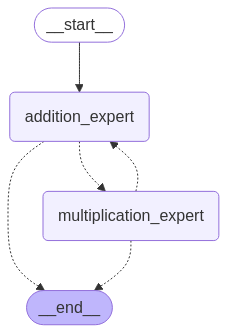

In [54]:
display(Image(app.get_graph().draw_mermaid_png()))

In [60]:
app.invoke({"messages": [HumanMessage(content="What is the result of 10 + 20?")]})

AI Message:  content='' additional_kwargs={'tool_calls': [{'id': 'call_6x8j', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 365, 'prompt_tokens': 174, 'total_tokens': 539, 'completion_time': 1.327272727, 'prompt_time': 0.011821296, 'queue_time': 0.053917214, 'total_time': 1.339094023}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-ece05c0e-540d-4360-9951-0403daabe627-0' tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_6x8j', 'type': 'tool_call'}] usage_metadata={'input_tokens': 174, 'output_tokens': 365, 'total_tokens': 539}
AI Message:  content='' additional_kwargs={'tool_calls': [{'id': 'call_fmv4', 'function': {'arguments': '{}', 'name': 'transfer_to_addition_expert'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 2

{'messages': [HumanMessage(content='What is the result of 10 + 20?', additional_kwargs={}, response_metadata={}, id='3e0ba3b9-dde1-4830-b730-87f5d586897f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6x8j', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 365, 'prompt_tokens': 174, 'total_tokens': 539, 'completion_time': 1.327272727, 'prompt_time': 0.011821296, 'queue_time': 0.053917214, 'total_time': 1.339094023}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ece05c0e-540d-4360-9951-0403daabe627-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_6x8j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 365, 'total_tokens': 539}),
  ToolMessage(content='Successfully Transferred', id='a667531b-0a9

In [58]:
print(app.invoke({"messages": [HumanMessage(content="What is the result of (30 + 40) * 50 ?")]}))

AI Message:  content='' additional_kwargs={'tool_calls': [{'id': 'call_kcgh', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 348, 'prompt_tokens': 355, 'total_tokens': 703, 'completion_time': 1.2654545449999999, 'prompt_time': 0.016955017, 'queue_time': -1.5848979389999998, 'total_time': 1.282409562}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-b4858a98-ee28-4387-844e-85498b6732a9-0' tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_kcgh', 'type': 'tool_call'}] usage_metadata={'input_tokens': 355, 'output_tokens': 348, 'total_tokens': 703}
AI Message:  content='The result of (30 + 40) * 50 is 3500.\n\n**Step-by-Step Explanation:**\n\n1. **Solve the addition inside the parentheses:**\n   - 30 + 40 = 70\n\n2. **Multiply the result by 50:**\n   - 70 * 5

In [63]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")
        
# Streaming the input
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12 + 100. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)        

AI Message:  content='' additional_kwargs={'tool_calls': [{'id': 'call_40jd', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 374, 'prompt_tokens': 182, 'total_tokens': 556, 'completion_time': 1.3599999999999999, 'prompt_time': 0.011316514, 'queue_time': 0.049506175, 'total_time': 1.371316514}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-3976149c-7e8e-4cdc-aabb-bf13a012d3c5-0' tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_40jd', 'type': 'tool_call'}] usage_metadata={'input_tokens': 182, 'output_tokens': 374, 'total_tokens': 556}
****chunk...****
Update from node addition_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_40jd)
 Call ID: call_40jd
  Args:
